In [4]:
import prose.datainsights as di
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from sklearn.decomposition import PCA
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os
import sys
from IPython.display import HTML
import warnings
from matplotlib import rc
from matplotlib import rcParams

warnings.filterwarnings('ignore')
rcParams['font.family'] = 'sans-serif'
rc('text', usetex=True)
systemName = 'CCSynth'

In [39]:
window_sizes = {
    "1CDT":400,
    "2CDT":400,
    "1CHT":400,
    "2CHT":400,
    "4CR":2000, #400,
    "4CRE-V1":1000,
    "4CRE-V2":1000,
    "5CVT":1000,
    "1CSurr":600,
    "4CE1CF":7500, #750,
    "UG-2C-2D":1000,
    "MG-2C-2D":2000,
    "FG-2C-2D":2000,
    "UG-2C-3D":2000,
    "UG-2C-5D":2000,
    "GEARS-2C-2D":2000,
}
        
def get_df(dataset, raw=True):
    df = pd.read_csv(os.path.join('Datasets', 'uncompressed', 'EVL', dataset) + ".txt", header=None)
    return df

def get_violations(approach, dataset, window):   
    df = get_df(dataset)
    max_self_violation_threshold = 0.15
    assertions = di.learn_assertions(df[:window], max_self_violation = max_self_violation_threshold)      
    n_chunks = int(df.shape[0]/window)
    violations = []
    for i in range(n_chunks):            
        test_df = df[i * window: (i + 1) * window]
        result = assertions.evaluate(test_df, normalizeViolation=False)
        violations.append(result.avg_violation)     
    
    return violations

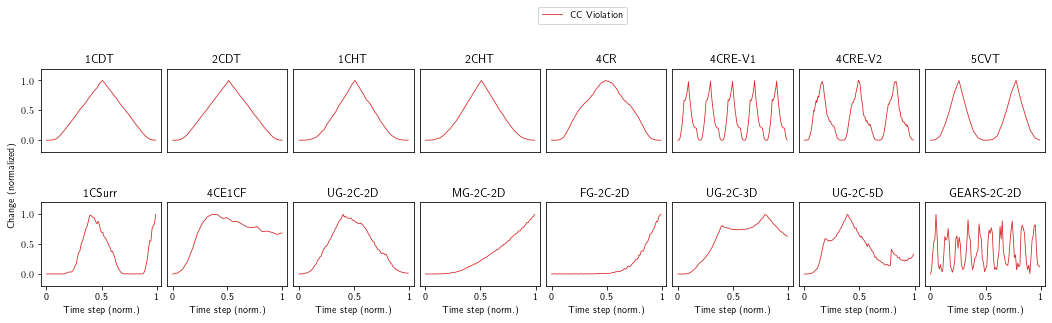

In [42]:
approach = "CCSynth"
color = "C3"
ls = '-'
nCol = 8

fig, ax = plt.subplots(2, nCol)
fig.set_size_inches(18, 4)

cur_plot_idx = 0

for dataset, window in window_sizes.items():          
    violations = get_violations(approach, dataset, window)             
    cur_plot = ax[cur_plot_idx//nCol][cur_plot_idx%nCol]

    if max(violations) > 0:
        violations = (violations - np.min(violations))/(np.max(violations) - np.min(violations))    

    cur_plot.plot(violations, color=color, linestyle=ls, label='CC Violation', linewidth=0.8)  
    cur_plot.set_title(dataset)
    cur_plot.set_ylim(-0.2, 1.2)

    if cur_plot_idx % nCol == 0:
        cur_plot.set_yticks(np.arange(0, 1.1, 0.5))        
    else:
        cur_plot.set_yticks([])

    if cur_plot_idx == nCol:
        cur_plot.set_ylabel("Change (normalized)", position=(1, 1.2))


    if cur_plot_idx >= nCol:
        cur_plot.set_xticks(np.arange(0, len(violations) + 1, len(violations)//2))            

        labels = cur_plot.get_xticks().tolist()

        labels[0] = "0"
        labels[1] = "0.5"
        labels[2] = "1"

        cur_plot.set_xticklabels(labels)
        cur_plot.set_xlabel("Time step (norm.)")
    else:
        cur_plot.set_xticks([])        

    if cur_plot_idx == 0:
        cur_plot.legend(ncol=4,loc="upper center", bbox_to_anchor=[4.2,1.8],)
    
    cur_plot_idx += 1

fig.subplots_adjust(hspace=0.6, wspace=0.05)
plt.savefig(os.path.join("EVL-Drift.pdf"), bbox_inches="tight")
plt.show()